In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Make sure that you have the dependency installed on your system
# If not installed, install by running the following
!pip install kafka-python

## Import required libraries

In [ ]:
import pandas as pd
import ast
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, accuracy_score
from google.colab import files
import io
from imblearn.combine import SMOTETomek
import time
from sklearn.preprocessing import StandardScaler
# Import the python Consumer Client for Kafka
from kafka import KafkaConsumer
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import precision_recall_fscore_support as score
import numpy as np

In [ ]:
def get_static_data(file_name):
  data = files.upload()
  return data

In [ ]:
data = get_static_data('cicids_static_data.csv')

Saving cicids_static_data.csv to cicids_static_data.csv


In [ ]:
def read_data(data):
  df = pd.read_csv(io.BytesIO(data['cicids_static_data.csv']))
  return df

In [ ]:
def read_streaming():
  df = pd.DataFrame()
  data_list = []
  # instantiate the KafkaConsumer Class using the arguments mentioned.
  consumer = KafkaConsumer(
      # write your arguments values
      'task_name', 
      bootstrap_servers="",
      sasl_plain_username="",
      sasl_plain_password="",
      security_protocol="",
      sasl_mechanism="",
      auto_offset_reset='',
      enable_auto_commit=
  )

  # Data Stream flowing in.
  i = 0
  for message in consumer:
    try:
      # print(f"Consuming the {i+1}th data packet!")
        
      data_packet = message.value
      # print(data_packet)
          
      ##############################################
      dict_str = data_packet.decode("UTF-8")
      dict_ = ast.literal_eval(dict_str)

      dff = pd.DataFrame.from_records([dict_])
      data_list.append(dff)
    
    except:
      continue

      ##############################################
      
    if i == 4999:
      break

    i += 1

  return data_list

In [ ]:
# aet stream data in a dataframe
def get_stream_as_df(df, data_list):
  for i in range(len(data_list)):
    df = df.append(data_list[i], ignore_index=True)
  return df

In [ ]:
#split data frame into features and labels
def get_feature_label(df):
  # set the features of the traffic into X
  X = df.drop(labels = ["Label"], axis=1) 
  # print(len(X))

  # set the labels of the traffic into y
  y = df["Label"].values
  # print(len(y))
  
  return X, y

In [ ]:
# method to know which columns conain inf values
def get_inf_col(dataset):
  col_inf = dataset[dataset==float("inf")].any()
  inf_list = []
  for i in range(len(col_inf)):
    if(col_inf[i] == True):
      inf_list.append(dataset.columns[i])

  return inf_list

In [ ]:
# replace inf values with the median of its column
def replace_inf_median(inf_list, dataset):
  for i in inf_list:
    for j in range(len(dataset[i])):
      if(dataset[i][j] == float("inf")):
        dataset[i][j] = dataset[i].median()

  return dataset

In [ ]:
#method to knowthe columnswhich contain null values
def get_col_with_null(dataset):
  nan_values = dataset.isna()
  nan_columns = nan_values.any()
  columns_with_nan = dataset.columns[nan_columns].tolist()
  
  return columns_with_nan

In [ ]:
#replace null values with the mean of their columns
def replace_na_mean(columns_with_nan, dataset):
  dataset[columns_with_nan] = dataset[columns_with_nan].fillna((dataset[columns_with_nan].mean()))
  return dataset

In [ ]:
def do_preprocessing(X, y):

  ## get columns which contains inf values and replaces those valueswith their column's median
  inf_col = get_inf_col(X)
  X = replace_inf_median(inf_col, X)

  ## get columns which contains nan values and replaces those valueswith their column's mean
  na_col = get_col_with_null(X)
  X = replace_na_mean(na_col, X)

  # scale the features of the traffic using standard scaler
  scaler = StandardScaler()
  scaler.fit(X)
  X_scaled = scaler.transform(X)

  # apply features selection for the coming traffic based on the number of features that is the static model trained on which equal to 66 feature 
  n_fea = SelectKBest(score_func=f_classif, k=66)
  fit = n_fea.fit(X_scaled, y)
  set_printoptions(precision=3)
  features = fit.transform(X_scaled)
  # print(features)
  return features, y

In [ ]:
#read the saved model
def get_model():
  filename = 'finalized_model.sav'
  model = pickle.load(open(filename, 'rb'))
  return model

In [ ]:
#test streaming data with the model
def test_stream(model, x, y):
  pred = model.predict(x)
  result = model.score(x, y)
  return pred, result

In [ ]:
def plot_conf_mat(model, x, y):
  plot_confusion_matrix(model, x, y)  
  plt.show()

In [ ]:
#method which returns the average macro precision, recall and F1_score
def get_performance_rport(y, pred):
  # clf_report = classification_report(y, pred, output_dict=True)
  precision,recall,fscore,support=score(y, pred, average='macro')
  return precision, recall, fscore

In [ ]:
#method to collect model performance in each iteration
def save_model_performance(test_performance, test_acc, precision, recall, fscore, acc):
  test_performance = test_performance.append({'precision' : precision, 'recall' : recall, 'fscore' : fscore}, 
                ignore_index = True)
  
  test_acc = test_acc.append({'accuracy' : acc}, 
                ignore_index = True)
  return test_performance, test_acc

In [ ]:
#method to remove 5000 record from the head of static data frame, as a part of forgetting mechanism
def remove_part_static(df_static, new_len):
  # df_static.drop(df_static.head(new_len).index, inplace=True)
  df_static = df_static.iloc[new_len:]
  return df_static

In [ ]:
#method to add the new 5000 streaming record to the tail of the static dataframe
def add_part_streaam(df_static, df_stream):
  df_static = df_static.append(df_stream, ignore_index = True)
  return df_static

In [ ]:
# I created that method to balance data. 
#but later I decide to work with the data as it is (imbalanced")


# def sampling_data(X_train, y_train):
#   sm = SMOTETomek()
#   X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
#   return X_resampled, y_resampled

In [ ]:
#method to retrain the adaptive model
def retrain_model(model, X_resampled, y_resampled):
  model.fit(X_resampled, y_resampled)
  return model

In [ ]:
#method which combine the whole process
def run_process():
  start = time.time()

  test_performance_stream = pd.DataFrame(columns = ['precision', 'recall', 'fscore'])
  test_acc_stream = pd.DataFrame(columns=['accuracy'])

  test_performance_static = pd.DataFrame(columns = ['precision', 'recall', 'fscore'])
  test_acc_static = pd.DataFrame(columns=['accuracy'])

  # data = get_static_data('cicids_static_data.csv')
  df_static = read_data(data)
  static_model = get_model()
  adaptive_model = get_model()
  for i in range(20):
    data_list = []
    data_list = read_streaming()

    df = pd.DataFrame()
    df = get_stream_as_df(df, data_list)
    df.columns = df_static.columns

    X, y = get_feature_label(df)
    
    features, y = do_preprocessing(X, y)

    # test performance of static model on stream data
    pred_1, score_1 = test_stream(static_model, features, y)
    print("Score of static model on testing streaming data iS: ", score_1)
    plot_conf_mat(static_model, features, y)
    precision, recall, fscore = get_performance_rport(y, pred_1)
    test_performance_static, test_acc_static = save_model_performance(test_performance_static, test_acc_static, precision, recall, fscore, score_1)
  

    #Test performance of adaptive model on stream data  
    pred, score = test_stream(adaptive_model, features, y)
    print("Score of adaptive model on testing streaming data iS: ", score)
    plot_conf_mat(adaptive_model, features, y)
    precision, recall, fscore = get_performance_rport(y, pred)
    test_performance_stream, test_acc_stream = save_model_performance(test_performance_stream, test_acc_stream, precision, recall, fscore, score)
    
    # plot the numbers of BENIGN and ATTACK traffic
    g = sns.countplot(y)
    g.set_xticklabels(['BENIGN','ATTACK'])
    plt.show()

    #remove 5000 record from the head of static dataset
    # print(len(df_static), "before remove")
    df_static = remove_part_static(df_static, len(df))
    # print(len(df_static), "after remove")

    #add 500 stream records to the tail of static dataset
    df_static = add_part_streaam(df_static, df)
    # print(len(df_static), "after add")

    XX, yy = get_feature_label(df_static)
    
    features_new, y_new = do_preprocessing(XX, yy)
    # print(len(features_new), len(y_new))

    # features_new, y_new = sampling_data(features_new, y_new)

    adaptive_model = retrain_model(adaptive_model, features_new, y_new)

  end = time.time()
  print("Time needed to run the whole process is: ", (end - start))
  return test_performance_static, test_acc_static, test_performance_stream, test_acc_stream

Score of static model on testing streaming data iS:  0.9592


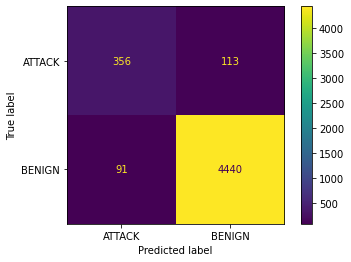

Score of adaptive model on testing streaming data iS:  0.9592


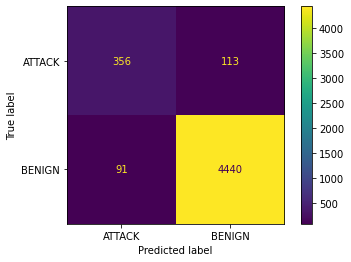

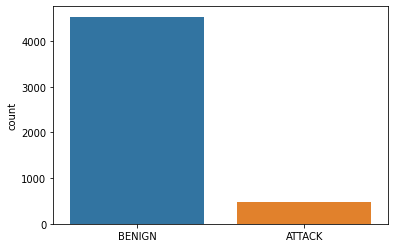

Score of static model on testing streaming data iS:  0.9592


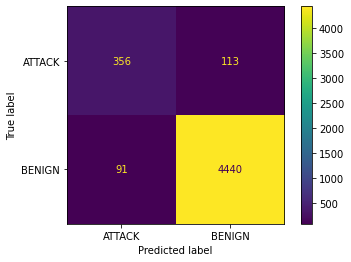

Score of adaptive model on testing streaming data iS:  0.4534


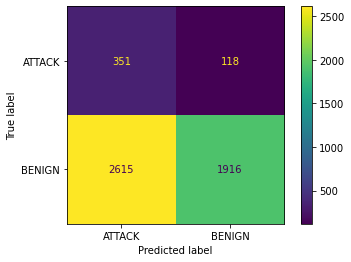

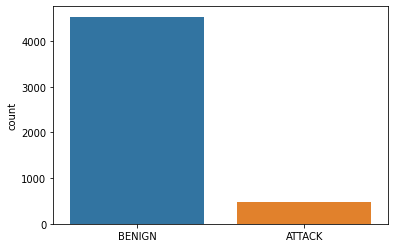

Score of static model on testing streaming data iS:  0.9592


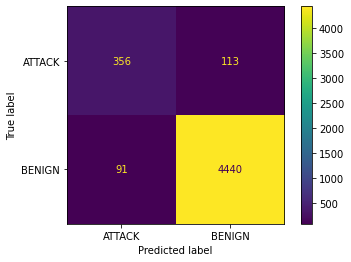

Score of adaptive model on testing streaming data iS:  0.7696


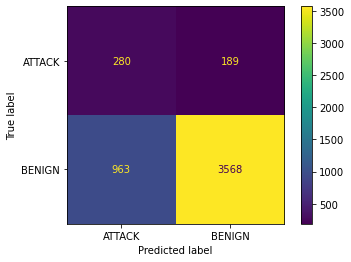

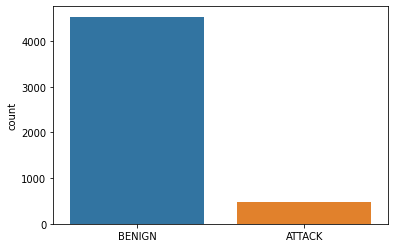

Score of static model on testing streaming data iS:  0.8342


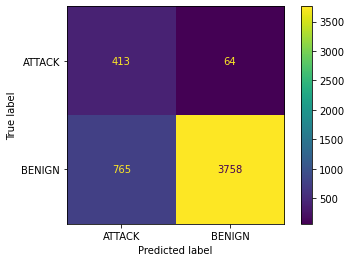

Score of adaptive model on testing streaming data iS:  0.5848


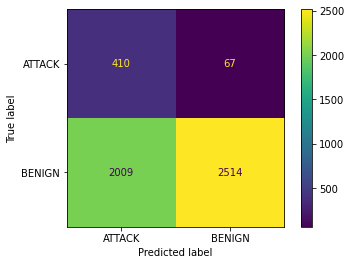

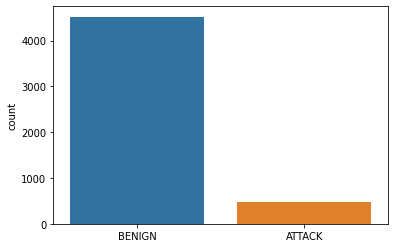

Score of static model on testing streaming data iS:  0.9592


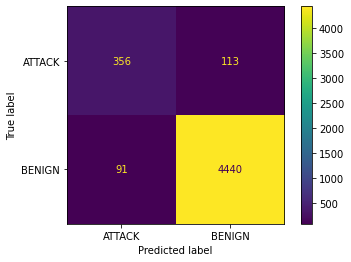

Score of adaptive model on testing streaming data iS:  0.9332


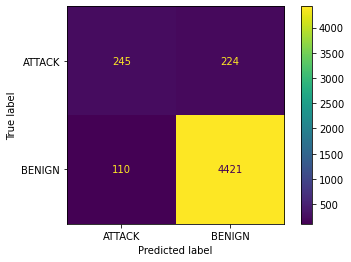

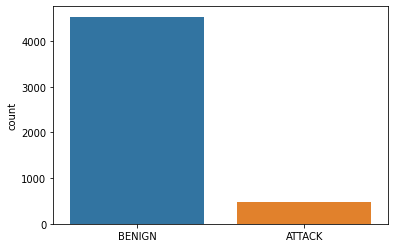

Score of static model on testing streaming data iS:  0.9146


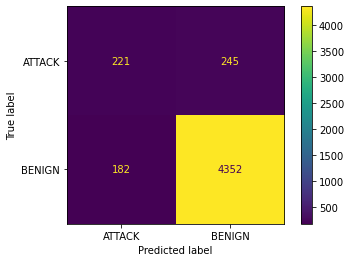

Score of adaptive model on testing streaming data iS:  0.9424


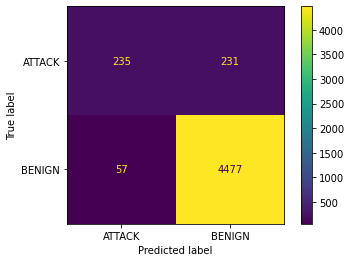

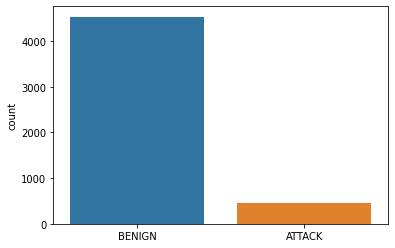

Score of static model on testing streaming data iS:  0.8342


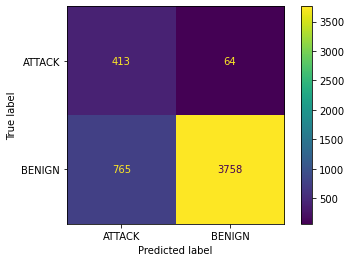

Score of adaptive model on testing streaming data iS:  0.8856


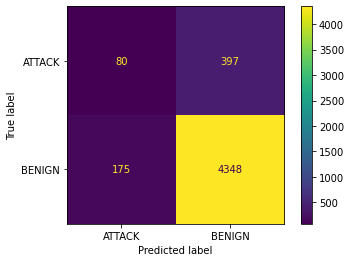

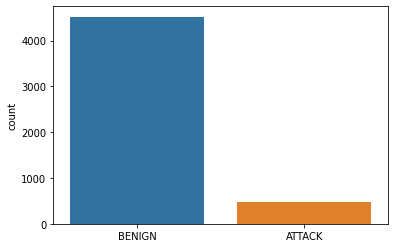

Score of static model on testing streaming data iS:  0.9592


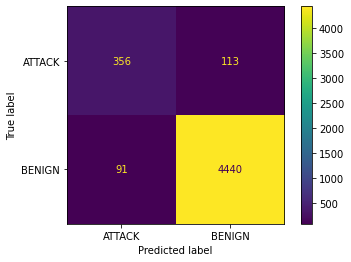

Score of adaptive model on testing streaming data iS:  0.9486


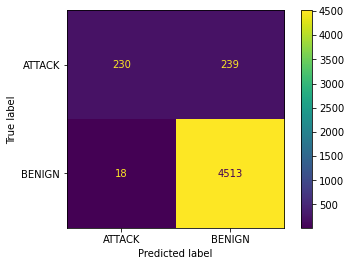

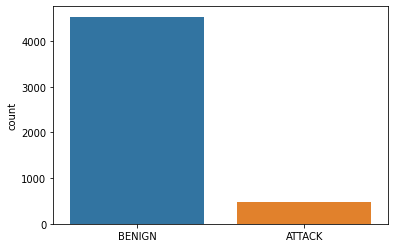

Score of static model on testing streaming data iS:  0.8342


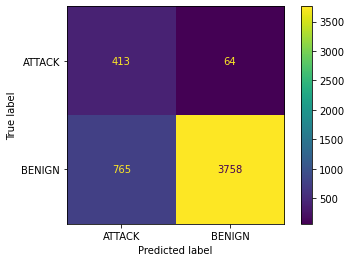

Score of adaptive model on testing streaming data iS:  0.966


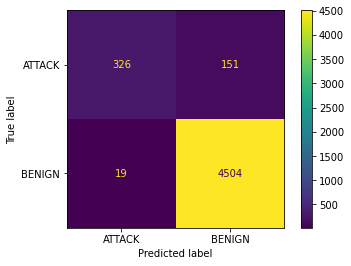

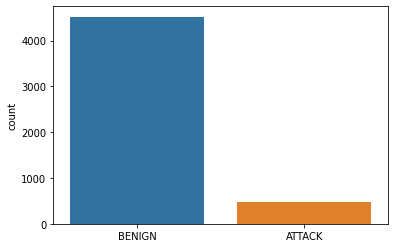

Score of static model on testing streaming data iS:  0.9146


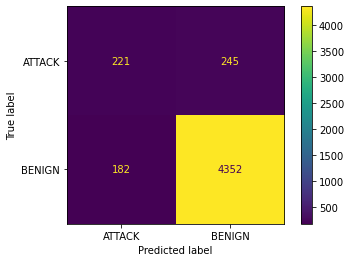

Score of adaptive model on testing streaming data iS:  0.9266


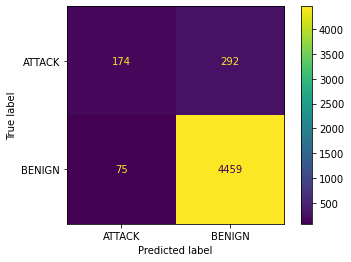

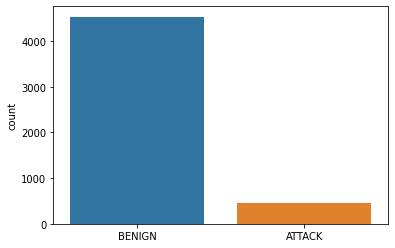

Score of static model on testing streaming data iS:  0.9592


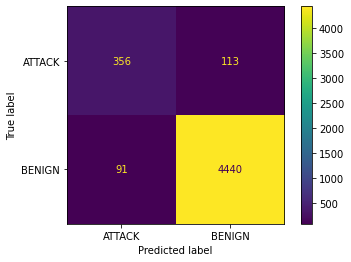

Score of adaptive model on testing streaming data iS:  0.9496


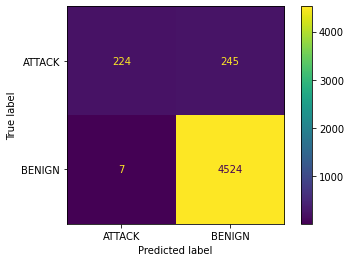

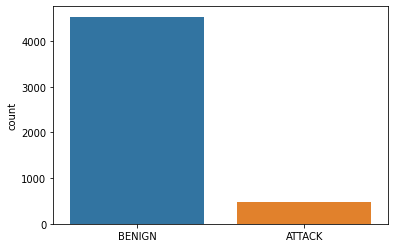

Score of static model on testing streaming data iS:  0.9592


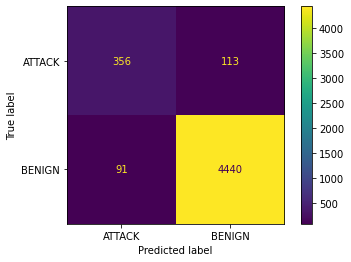

Score of adaptive model on testing streaming data iS:  0.9362


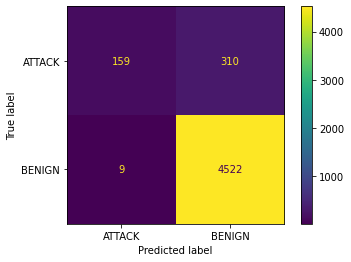

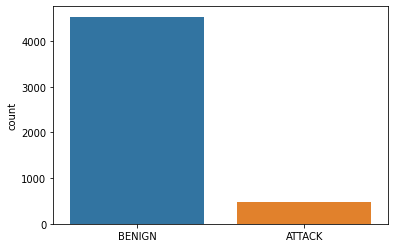

Score of static model on testing streaming data iS:  0.9146


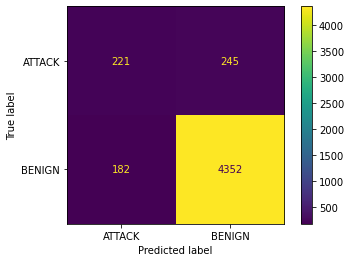

Score of adaptive model on testing streaming data iS:  0.9476


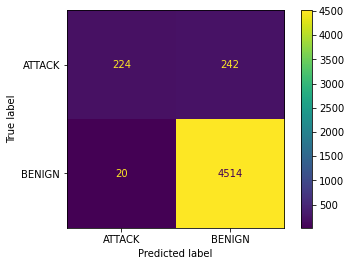

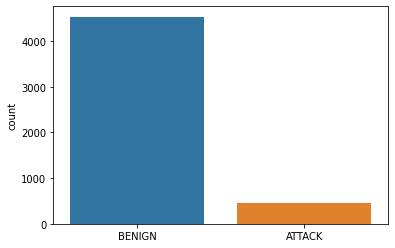

Score of static model on testing streaming data iS:  0.9146


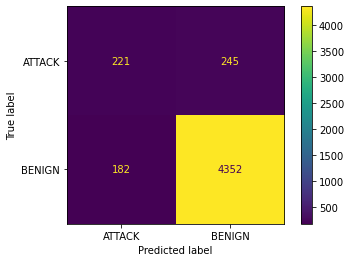

Score of adaptive model on testing streaming data iS:  0.9432


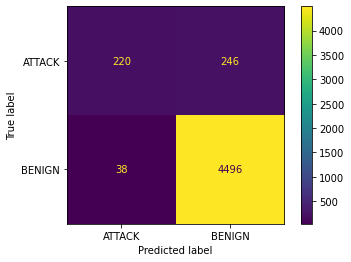

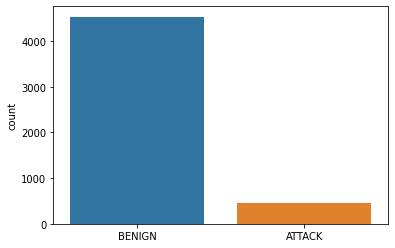

Score of static model on testing streaming data iS:  0.9146


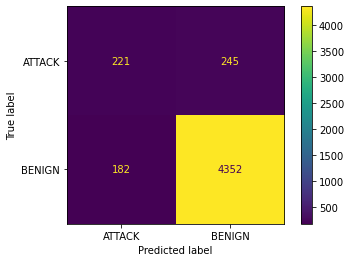

Score of adaptive model on testing streaming data iS:  0.9472


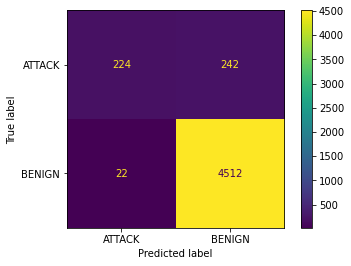

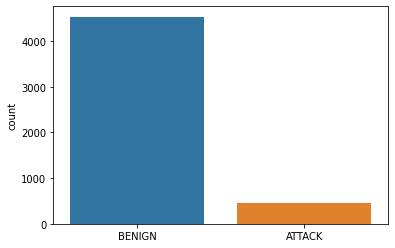

Score of static model on testing streaming data iS:  0.8342


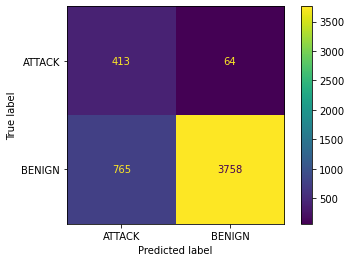

Score of adaptive model on testing streaming data iS:  0.9462


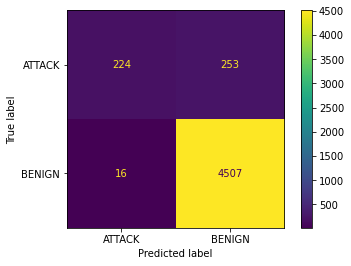

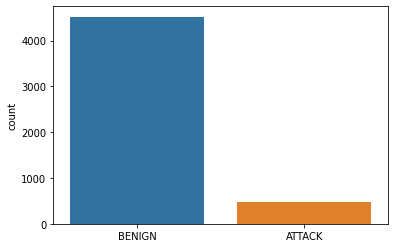

Score of static model on testing streaming data iS:  0.9592


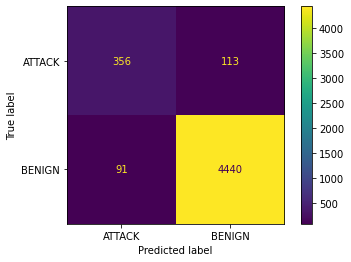

Score of adaptive model on testing streaming data iS:  0.9462


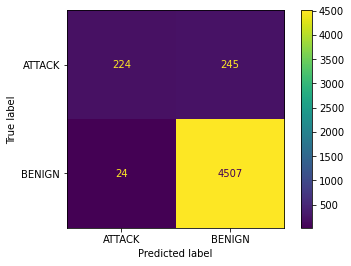

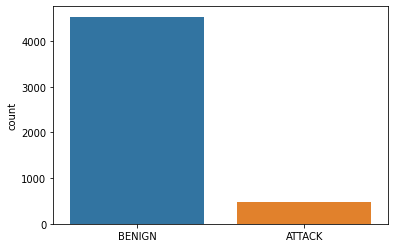

Score of static model on testing streaming data iS:  0.9146


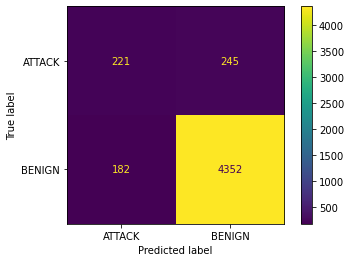

Score of adaptive model on testing streaming data iS:  0.9424


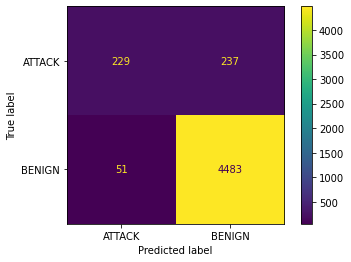

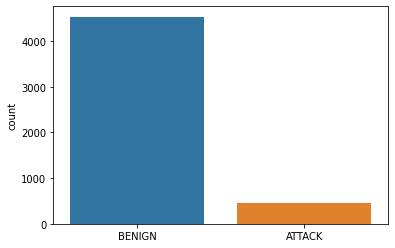

Score of static model on testing streaming data iS:  0.9592


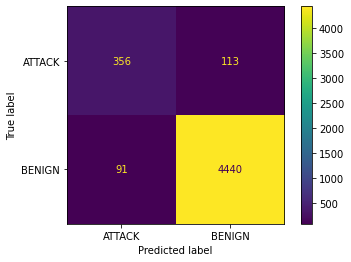

Score of adaptive model on testing streaming data iS:  0.9462


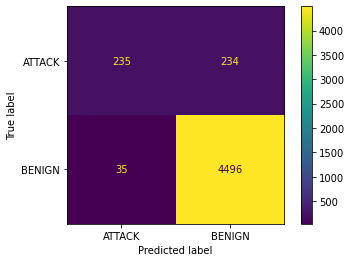

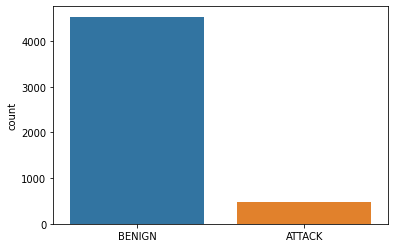

Score of static model on testing streaming data iS:  0.9146


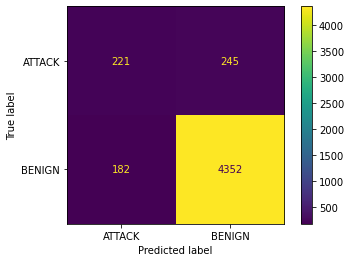

Score of adaptive model on testing streaming data iS:  0.9004


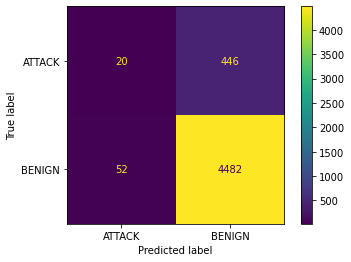

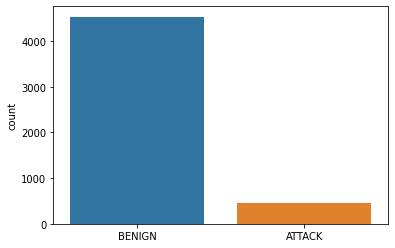

Time needed to run the whole process is:  1656.0638573169708


In [ ]:
performance_static, performance_acc_static, performance_stream, performance_acc_stream = run_process()

In [ ]:
#array of number of iterations, to plot line graphs for precision, recalland f1_score
run_times = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [ ]:
#get accuracy, precision, recall anf f1_score of static model in a separate lists
acc_static_list = performance_acc_static['accuracy'].tolist()
prec_static_list = performance_static['precision'].tolist()
recall_static_list = performance_static['recall'].tolist()
fscore_static_list = performance_static['fscore'].tolist()

In [ ]:
#get accuracy, precision, recall anf f1_score of adaptive model in a separate lists
acc_stream_list = performance_acc_stream['accuracy'].tolist()
prec_stream_list = performance_stream['precision'].tolist()
recall_stream_list = performance_stream['recall'].tolist()
fscore_stream_list = performance_stream['fscore'].tolist()

In [ ]:
# method to plot line graph for any given accuracy, precision, recall or f1_score
def plot_performance_graph(X, y1, y2, metric_sta, metric_str, X_title, y_title, metric):
  width = 10
  height = 8
  graph_shape = (width, height)
  plt.figure(figsize=graph_shape)
  plt.xticks(np.arange(len(X)+1), np.arange(0, len(X)+1))

  plt.plot(X, y1, label = metric_sta)
  plt.plot(X, y2, label = metric_str)
  plt.xlabel(X_title)
  plt.ylabel(y_title)

  plt.title('Model '+ metric + ' on static and stream data')
  plt.legend()
  plt.show()

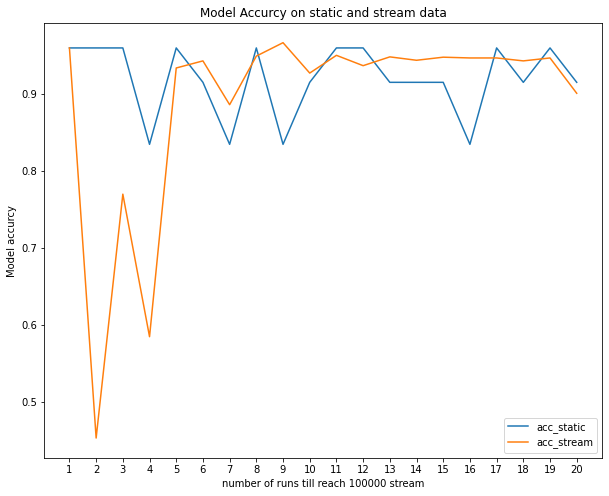

In [ ]:
#plot line graph to compare between accuracy of static and adaptive models
plot_performance_graph(run_times, acc_static_list, acc_stream_list, "acc_static", "acc_stream", "number of runs till reach 100000 stream", "Model accurcy", "Accurcy")

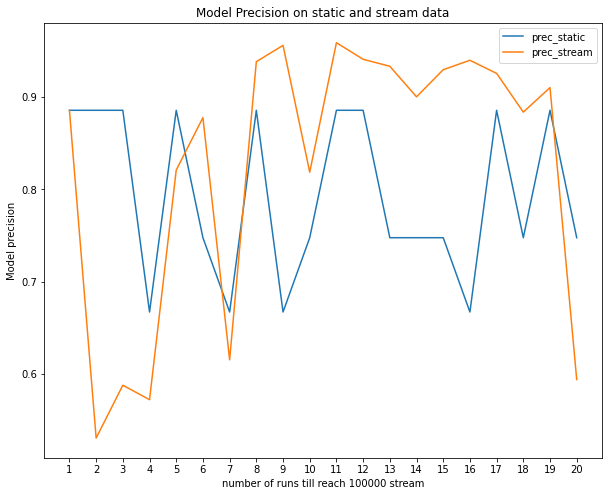

In [ ]:
#plot line graph to compare between precision of static and adaptive models
plot_performance_graph(run_times, prec_static_list, prec_stream_list, "prec_static", "prec_stream", "number of runs till reach 100000 stream", "Model precision", "Precision")

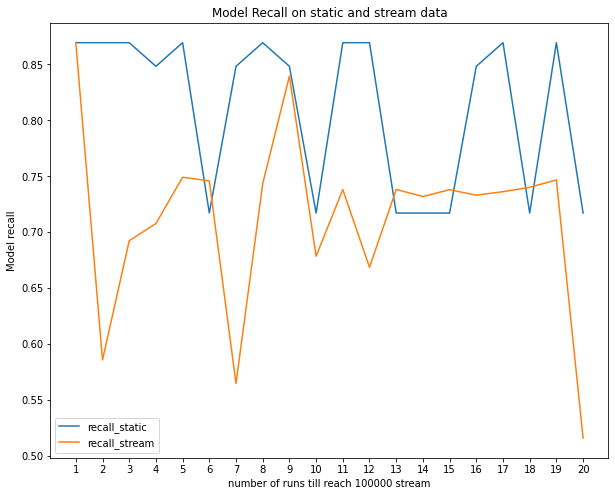

In [ ]:
#plot line graph to compare between recall of static and adaptive models
plot_performance_graph(run_times, recall_static_list, recall_stream_list, "recall_static", "recall_stream", "number of runs till reach 100000 stream", "Model recall", "Recall")

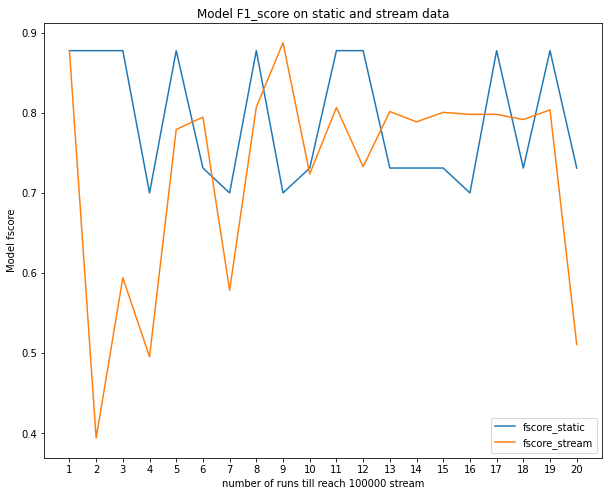

In [ ]:
#plot line graph to compare between f1_score of static and adaptive models
plot_performance_graph(run_times, fscore_static_list, fscore_stream_list, "fscore_static", "fscore_stream", "number of runs till reach 100000 stream", "Model fscore", "F1_score")

## References:
1. pandas, D. and Algiriyage, N., 2013. Delete the first three rows of a dataframe in pandas. [online] Stack Overflow. Available at: <https://stackoverflow.com/questions/16396903/delete-the-first-three-rows-of-a-dataframe-in-pandas>
2. w3resource. 2020. Matplotlib Basic: Plot two or more lines on same plot with suitable legends of each line - w3resource. [online] Available at: <https://www.w3resource.com/graphics/matplotlib/basic/matplotlib-basic-exercise-5.php>
3. GeeksforGeeks. 2020. How to create an empty DataFrame and append rows & columns to it in Pandas? - GeeksforGeeks. [online] Available at: <https://www.geeksforgeeks.org/how-to-create-an-empty-dataframe-and-append-rows-columns-to-it-in-pandas/>